In [45]:
import pandas as pd
import numpy as np
import json
import nltk
import string
import re
import sys
sys.path.append("../")
from scripts.start import iberEval, sexists
from scripts.data_utils import get_balanced_data
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
tweets,categories,sources = get_balanced_data(500)

In [3]:
dfCat = pd.DataFrame(categories, columns=["category"]).astype('category')
catCodes = dfCat['category'].cat.codes
catCodes

0        2
1        2
2        2
3        2
4        2
        ..
7953    18
7954    18
7955    18
7956    18
7957    18
Length: 7958, dtype: int8

In [4]:
np.unique(categories)

array(['abusive', 'benevolent sexism', 'cyberbullying', 'derailing',
       'discredit', 'dominance', 'hateful', 'homophobic',
       'hostile sexism', 'insult', 'obscene', 'offensive', 'profane',
       'racist', 'sexual_harassment', 'spam', 'stereotype', 'threat',
       'vulgar'], dtype='<U17')

In [26]:
from collections import Counter
Counter(categories)

Counter({'cyberbullying': 355,
         'offensive': 500,
         'spam': 500,
         'abusive': 500,
         'hateful': 500,
         'profane': 500,
         'discredit': 500,
         'sexual_harassment': 410,
         'derailing': 29,
         'stereotype': 137,
         'dominance': 49,
         'obscene': 500,
         'insult': 500,
         'threat': 478,
         'racist': 500,
         'homophobic': 500,
         'benevolent sexism': 500,
         'hostile sexism': 500,
         'vulgar': 500})

In [38]:
def tokenize_and_lemmatize(text):
    text = re.sub("[@]\w+", "", text) # remove tags
    # remove punctuation
    table = text.maketrans({key: None for key in string.punctuation})
    text = text.translate(table)
    text = re.sub("(http)\w+", "", text) # remove links
    tokens = nltk.word_tokenize(text)
    #lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

In [35]:
lemmatizer = WordNetLemmatizer()
englishwords = stopwords.words('english')
englishwords.extend(["u","rt","im","em","q","na","wan","’","“","”","…"])

In [16]:
for i in range(len(tweets)):
    tweets[i] = str(tweets[i])

In [39]:
tfidf_vec = TfidfVectorizer(max_df=0.95, 
                        max_features=10000,
                        min_df=10, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,1))

In [41]:
tfidf_mat = tfidf_vec.fit_transform(tweets)
tfidf_mat.shape

(7958, 1216)

In [46]:
clusters = MiniBatchKMeans(n_clusters=19, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_mat)
clusters = KMeans(n_clusters=19, random_state=20).fit_predict(tfidf_mat)

In [47]:
Counter(clusters)

Counter({16: 339,
         7: 431,
         0: 3170,
         3: 372,
         2: 259,
         14: 454,
         12: 293,
         8: 315,
         5: 453,
         17: 92,
         11: 100,
         4: 346,
         1: 217,
         18: 257,
         9: 169,
         6: 198,
         13: 196,
         10: 186,
         15: 111})

In [57]:
def plot_tsne_pca(data, labels,defLabels=None):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)

    pca = PCA(n_components=2).fit_transform(data.todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data.todense()))
    
    #idx = np.random.choice(range(pca.shape[0]), size=3000, replace=False)
    label_subset = labels#[max_items]
    #label_subset = labels[idx]


    f, ax = plt.subplots(1, 2, figsize=(26, 11))
    
    pts = ax[0].scatter(pca[:, 0], pca[:, 1], c=label_subset, cmap="jet")
    #print(pts.legend_elements()[0])
    ax[0].set_title('PCA Cluster Plot')
    #print(*pts.legend_elements())
    #print(tsne[:, 0].shape)
    pts2 = ax[1].scatter(tsne[:, 0], tsne[:, 1], c=label_subset, cmap="jet")
    ax[1].set_title('TSNE Cluster Plot')
    if defLabels is None:
        ax[0].legend(*pts.legend_elements(num=None))
        ax[1].legend(*pts2.legend_elements(num=None))
    else:
        ax[0].legend(pts.legend_elements(num=None)[0], defLabels)
        ax[1].legend(pts2.legend_elements(num=None)[0], defLabels)

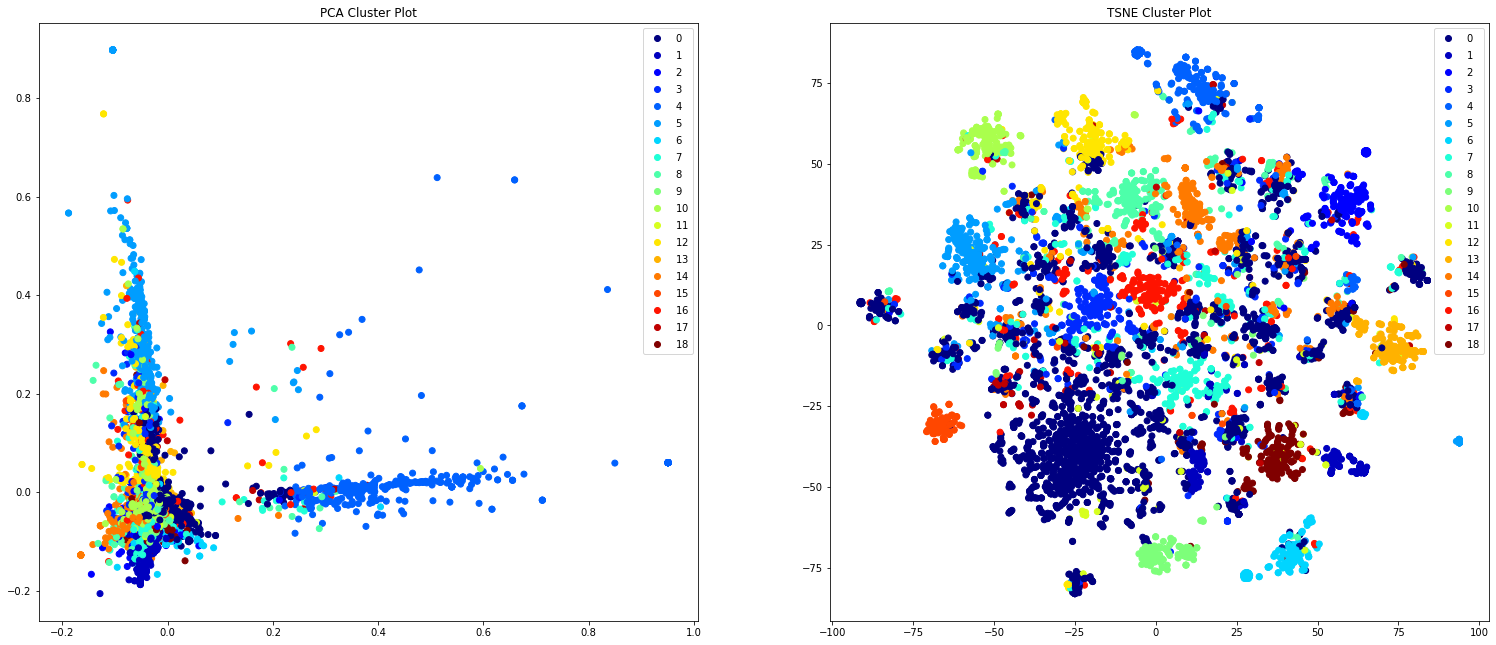

In [58]:
plot_tsne_pca(tfidf_mat, clusters)

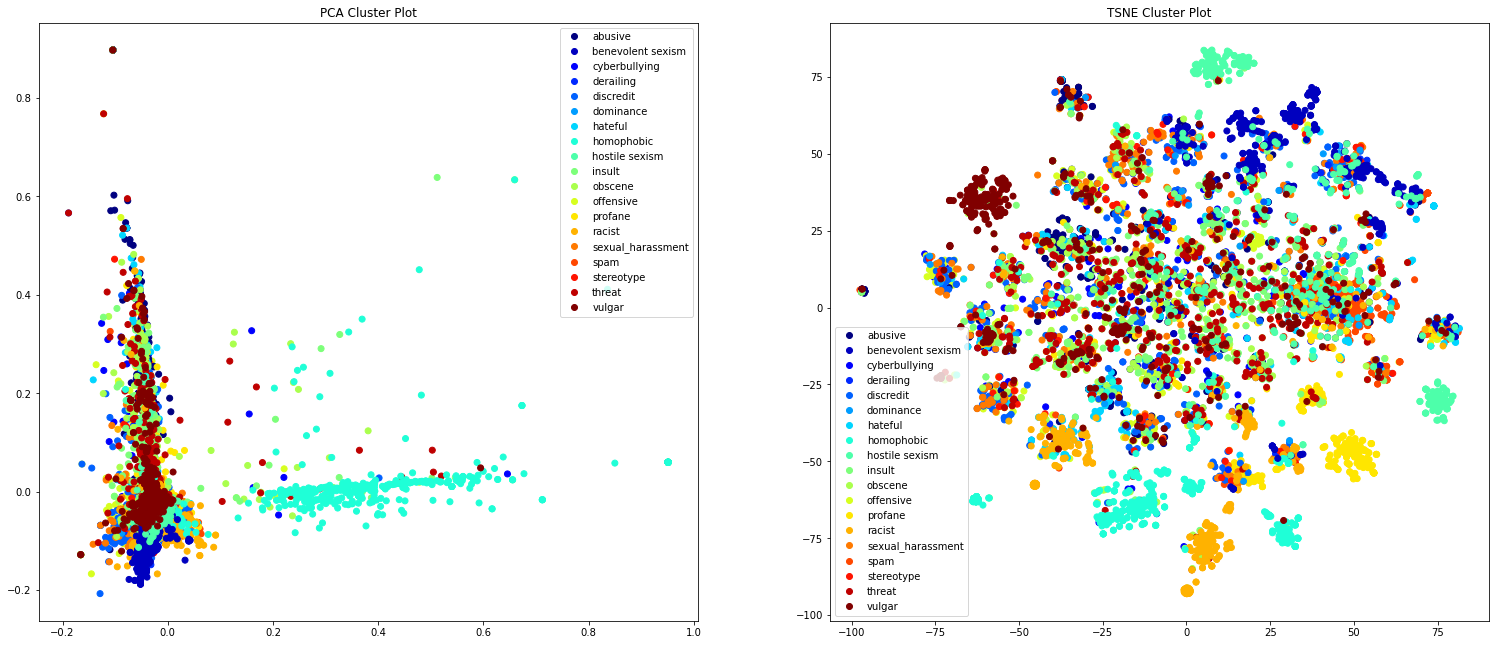

In [59]:
plot_tsne_pca(tfidf_mat, catCodes, np.unique(categories))

In [56]:
def get_top_keywords(data, clusters, labels, n_terms, categoryNames=None):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        if categoryNames is None:
            print('\nCluster {}'.format(i))
        else:
            print('\nCluster {}'.format(categoryNames[i]))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]][::-1]))
            
get_top_keywords(tfidf_mat, clusters, tfidf_vec.get_feature_names(), 15)


Cluster 0
fucked,girl,dyke,shit,’,bitches,one,youre,dick,amp,go,idiot,dickhead,pussy,new

Cluster 1
woman,man,love,good,lucky,without,last,first,luckier,womensday,like,awaken,loving,every,happy

Cluster 2
nigga,’,like,bitch,mad,hate,fuck,got,said,aint,dont,shit,yo,pussy,white

Cluster 3
dont,know,like,bitch,want,fuck,fucking,shit,people,go,care,say,think,dick,youre

Cluster 4
faggot,’,see,look,called,sissy,use,straight,fuck,shut,like,”,“,fucking,men

Cluster 5
fucking,hate,youre,go,cant,know,shit,racist,bush,bitch,george,calling,didnt,stupid,people

Cluster 6
nigger,’,“,”,fuck,get,say,call,shut,see,black,white,called,still,one

Cluster 7
like,man,bitch,look,act,shit,think,one,people,looks,cant,fucking,woman,really,know

Cluster 8
ass,bitch,ugly,stupid,fuck,pussy,shit,hoe,fuckin,face,fucking,dumb,like,dick,hate

Cluster 9
sexist,call,women,female,girls,football,womens,dont,woman,sports,females,cant,men,shouldnt,funny

Cluster 10
user,url,hell,shit,bitch,fucking,damn,fuck,ass,like,pisse

In [55]:
get_top_keywords(tfidf_mat, catCodes, tfidf_vec.get_feature_names(), 15, np.unique(categories))


Cluster abusive
fucking,fucked,bad,ass,like,cant,dont,hate,idiot,fuck,bitch,want,idiots,go,know

Cluster benevolent sexism
woman,man,love,womensday,like,women,good,without,girl,adaywithoutwomen,amp,internationalwomensday,happy,…,lucky

Cluster cyberbullying
bra,get,know,bitch,dont,fake,like,fuck,shit,lol,stop,ugly,ass,ur,bitchbra

Cluster derailing
women,rape,woman,men,lol,bitch,whore,dick,dress,dont,sexism,every,make,talking,pregnant

Cluster discredit
bitch,stupid,whore,hoe,girl,women,like,slut,ass,pussy,’,cunt,dick,fuck,woman

Cluster dominance
bitch,women,like,whore,yesallmen,men,girl,dick,shut,account,girls,cock,get,youre,know

Cluster hateful
niggas,hate,nigga,fucking,idiot,like,mad,dont,people,amp,idiots,ass,trump,us,crazy

Cluster homophobic
faggot,dyke,’,look,see,like,called,gay,straight,sissy,big,“,call,”,say

Cluster hostile sexism
sexist,mkr,kat,women,girls,notsexist,call,female,dont,men,think,woman,feminism,feminists,cant

Cluster insult
fuck,fucking,go,wikipedia,shit,don

Some clusters are clearly distinct and match some categories: eg. cluster 1 and benevolent sexism, cluster 4 and homophobic, cluster 13 and profane

In [60]:
homogeneity_score(clusters, catCodes)

0.3051504590832045